# Census Income Prediction

In [128]:
import urllib.request
import shutil

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path

### Load Data

In [2]:
PROJECT_PATH = Path('/home/ubuntu/flatworld/')
DATA_DIR = PROJECT_PATH / 'data'

In [3]:
with (DATA_DIR / 'census_income_metadata.txt').open('r') as fin:
    metadata_desc = fin.read()
metadata = metadata_desc.split('|')
metadata = [md.strip() for md in metadata][1:]

['This data was extracted from the census bureau database found at',
 'http://www.census.gov/ftp/pub/DES/www/welcome.html',
 'Donor: Terran Lane and Ronny Kohavi',
 'Data Mining and Visualization',
 'Silicon Graphics.',
 'e-mail: terran@ecn.purdue.edu, ronnyk@sgi.com for questions.',
 '',
 'The data was split into train/test in approximately 2/3, 1/3',
 "proportions using MineSet's MIndUtil mineset-to-mlc.",
 '',
 'Prediction task is to determine the income level for the person',
 'represented by the record.  Incomes have been binned at the $50K',
 'level to present a binary classification problem, much like the',
 'original UCI/ADULT database.  The goal field of this data, however,',
 'was drawn from the "total person income" field rather than the',
 '"adjusted gross income" and may, therefore, behave differently than the',
 'orginal ADULT goal field.',
 '',
 'More information detailing the meaning of the attributes can be',
 'found in http://www.bls.census.gov/cps/cpsmain.htm',
 'To 

In [4]:
col_info = [xx for xx in metadata if 'attribute #' in xx]

col_distinct = [int(col.split(' ')[0]) for col in col_info]
col_nums = [int(xx.split('#')[1][:2]) for xx in col_info]
col_types = [col[(col.find(')') + 2):] for col in col_info]
col_names = [col[col.find('(')+1:col.find(')')] for col in col_info]
# NOTE: Having chosen to pull column names from these lines was a bit unfortunate because
#  the 24th entry in the csv is actually the instance weight as shown in lines 24-68 of
#  the metadata text file. This is skipped over in these lines, so attribute # doesn't
#  actually correspond to column location in the csv. Seems like this should be
#  pointed out more explicitly somewhere in the file.

col_info_df = pd.DataFrame([xx for xx in zip(col_names, col_types, col_distinct)], columns=['col_names', 'col_type', 'col_distinct'], index=col_nums)
col_info_df.head()

,col_names,col_type,col_distinct
0,age,continuous,91
1,class of worker,nominal,9
2,detailed industry recode,nominal,52
3,detailed occupation recode,nominal,47
4,education,nominal,17


In [5]:
idxs = [xx for xx in range(42)]
idxs.pop(24)
idxs
col_names.append('target')
col_name_map = dict(zip(idxs, col_names))

{0: 'age',
 1: 'class of worker',
 2: 'detailed industry recode',
 3: 'detailed occupation recode',
 4: 'education',
 5: 'wage per hour',
 6: 'enroll in edu inst last wk',
 7: 'marital stat',
 8: 'major industry code',
 9: 'major occupation code',
 10: 'race',
 11: 'hispanic origin',
 12: 'sex',
 13: 'member of a labor union',
 14: 'reason for unemployment',
 15: 'full or part time employment stat',
 16: 'capital gains',
 17: 'capital losses',
 18: 'dividends from stocks',
 19: 'tax filer stat',
 20: 'region of previous residence',
 21: 'state of previous residence',
 22: 'detailed household and family stat',
 23: 'detailed household summary in household',
 25: 'migration code-change in msa',
 26: 'migration code-change in reg',
 27: 'migration code-move within reg',
 28: 'live in this house 1 year ago',
 29: 'migration prev res in sunbelt',
 30: 'num persons worked for employer',
 31: 'family members under 18',
 32: 'country of birth father',
 33: 'country of birth mother',
 34: 'coun

In [107]:
census_df = pd.read_csv(DATA_DIR / 'census_income_learn.csv',header=None)
instance_weights = census_df.pop(24)
census_df.rename(columns=col_name_map, inplace=True)
census_df['target'] = census_df['target'].apply(lambda x: int(x == ' 50000+.'))
census_df.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0


In [108]:
census_df['target'].value_counts()

0    187141
1     12382
Name: target, dtype: int64

## Explore Data

Below I do some basic data exploration to look for any data quality issues and to get an intuitive feel for the dataset.

###  Inspect Metadata statistics

In [45]:
col_info_df.sort_values('col_distinct', ascending=False)

,col_names,col_type,col_distinct
18,dividends from stocks,continuous,1478
5,wage per hour,continuous,1240
16,capital gains,continuous,132
17,capital losses,continuous,113
0,age,continuous,91
38,weeks worked in year,continuous,53
2,detailed industry recode,nominal,52
21,state of previous residence,nominal,51
3,detailed occupation recode,nominal,47
31,country of birth father,nominal,43


##### Thoughts:

1. The main issue that pops out to me here is the difficulty in **dealing with nominal (categorical) data that has a large number of categories**.
    * This is because when working with categorical data we typically preprocess the data by converting the single column with $N$ distinct values into $N$ columns which are binary encoded. e.g. if we have a column $\texttt{gender}$ with values $[\texttt{gender}] \in [\{\texttt{male, female, other}\}]$, then we map this column to three columns $[\texttt{gender}] \rightarrow [\texttt{gender_male, gender_female, gender_other}] \in [\{0, 1\}, \{0, 1\}, \{0, 1\}]$. However, for features with a large number of possible values this can cause the dimension of our feature space to increase dramatically, extending it beyond the capacity of our dataset.
    * A first approach to handle this type of issue is to simply try to ignore this dimension and see if the model performs adequately without it. This is what I will do now, but I imagine that this will be sub-optimal as some of these high-dimensional features contain superfically relevant information, e.g. indusrty and occupation codes. ***More on this below.***

In [46]:
# If we naively applied this methodology the dimension of our feature space would increase from 40 to
# such a large number it causes an integer overflow to calculate it
n_nom_cols_cart_prod = col_info_df[col_info_df['col_type'] == 'nominal']['col_distinct'].product()
n_cont_cols = col_info_df[col_info_df['col_type'] == 'continuous'].shape[0]
print('Dimensionality of naive feature space would be {}'.format(n_nom_cols_cart_prod * n_cont_cols))

Dimensionality of naive feature space would be 6353374019336536064


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in long_scalars


In [47]:
# # Download supplementary files from web
# urls = [
#     'https://www.census.gov/eos/www/naics/2002NAICS/2002_Definition_File.pdf',
#     'https://www.census.gov/eos/www/naics/reference_files_tools/2002/naics_2_6_02.txt'
# ]
# file_names = [
#     '2002_Definition_File.pdf',
#     'naics_2_6_02.txt'
# ]
# for url, file_name in zip(urls, file_names):
#     with urllib.request.urlopen(url) as response, open(DATA_DIR / file_name, 'wb') as out_file:
#         shutil.copyfileobj(response, out_file)

2. Though the data was categorized into $[\texttt{Data}] = [\texttt{continuous}] \otimes [\texttt{nominal}]$, this decomposition is perhaps a bit too coarse. **Nominal data assumes that there is no natural metric relationship between the categories, but this is not necessarily true, e.g. geographical data**, populations in nearby locations are more likely to be similar than between more distant locations.
    * ***Should be safe to ignore this additional information***, but should be kept in mind when it comes time to optimize the model.

### Inspect data for any obvious quality issues

In [49]:
# Check for nulls
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 41 columns):
age                                           199523 non-null int64
class of worker                               199523 non-null object
detailed industry recode                      199523 non-null int64
detailed occupation recode                    199523 non-null int64
education                                     199523 non-null object
wage per hour                                 199523 non-null int64
enroll in edu inst last wk                    199523 non-null object
marital stat                                  199523 non-null object
major industry code                           199523 non-null object
major occupation code                         199523 non-null object
race                                          199523 non-null object
hispanic origin                               199523 non-null object
sex                                           199523 non-null obj

In [50]:
cont_cols = col_info_df[col_info_df['col_type'] == 'continuous']['col_names'].values
nom_cols = col_info_df[col_info_df['col_type'] == 'nominal']['col_names'].values

#### Inspect continuous data

In [82]:
# Check continuously valued columns
census_df[sorted(cont_cols)].describe()

,age,capital gains,capital losses,dividends from stocks,num persons worked for employer,wage per hour,weeks worked in year
count,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,434.71899,37.313788,197.529533,1.956180,55.426908,23.174897
std,22.310895,4697.53128,271.896428,1984.163658,2.365126,274.896454,24.411488
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,0.00000,0.000000,0.000000,1.000000,0.000000,8.000000
75%,50.000000,0.00000,0.000000,0.000000,4.000000,0.000000,52.000000
max,90.000000,99999.00000,4608.000000,99999.000000,6.000000,9999.000000,52.000000


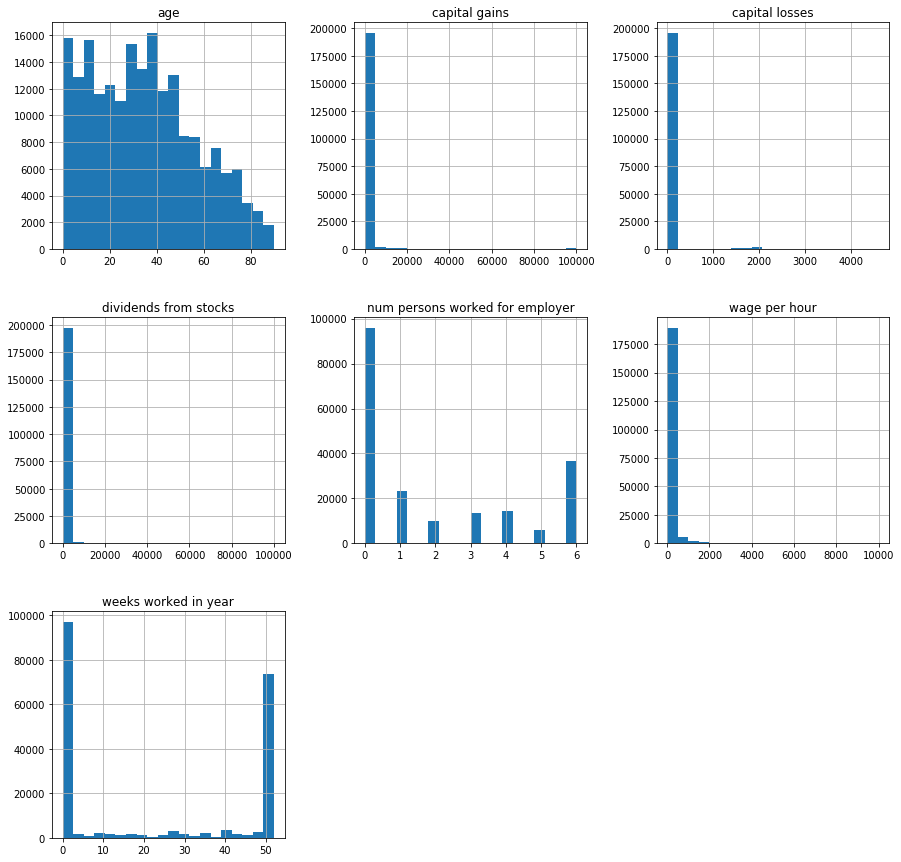

In [52]:
census_df[cont_cols].hist(bins=20, figsize=(15,15))
plt.show()

##### Sanity Check
* **age** - average age of 35, min of 0, max of 90 seems reasonable
* **capital gains** - vast majority of population has very litle in capital gains, however a few wealthy and ultra-wealthy gaining a significant sum.
* **capital losses** - vast majority of population has very little capital losses, however in contrast to capital gains, it is far less bimodal and evenly distributed
* **dividends from stocks** - again, dominated by low values, but also shows the bimodality of capital gains, but less pronounced
* **num persons worked for employer** - size of employer *(Note: ***NOT*** the literal number of employees, but rather a category http://www.nber.org/cps/cpsmar11.pdf)*
* **wage per hour** - reasonable, shows that a distribution peaked at low values, but with long tails

In [145]:
def compare_hist(field, thresh=0, bins=25, sharex=True, sharey=False):
    colors = {
        'tot': '#5D3A72',
        'pos': '#A85153',
        'neg': '#4B5872'
    }
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=sharex, sharey=sharey)
    ax[0].hist(census_df[census_df[field] > thresh][field].values , bins=bins, color=colors['tot'], label='Total')
    ax[1].hist(census_df[(census_df[field] > thresh) & (census_df['target'] == 1)][field].values, bins=bins, color=colors['pos'], label='>50000')
    ax[2].hist(census_df[(census_df[field] > thresh) & (census_df['target'] == 0)][field].values, bins=bins, color=colors['neg'], label='<50000')
    [a.legend(loc='upper right') for a in ax]
    ax[0].set_ylabel(field)
    fig.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


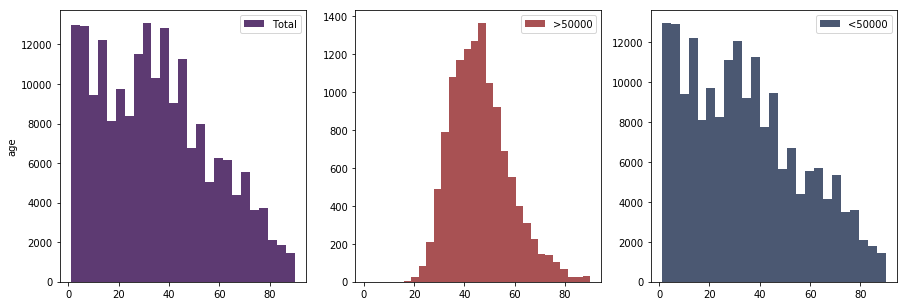

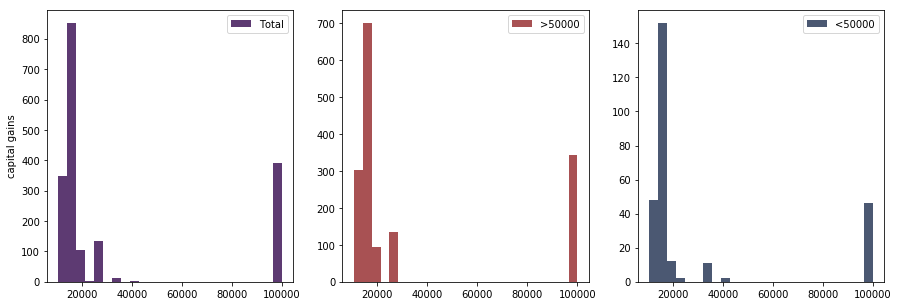

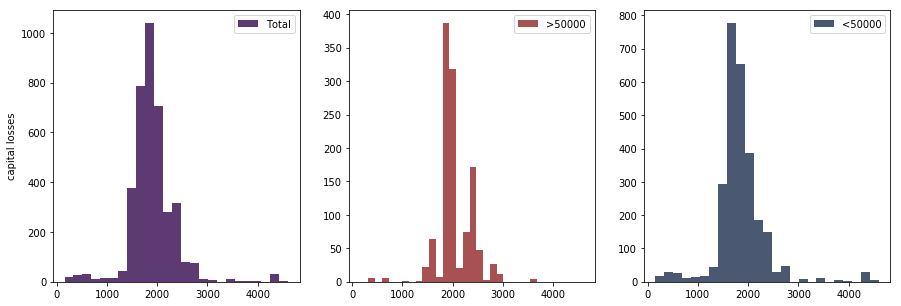

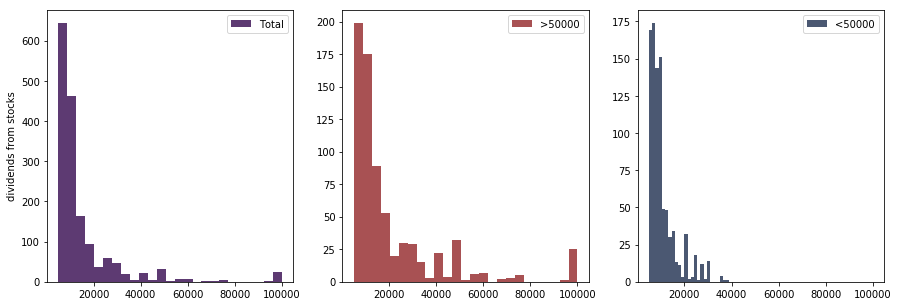

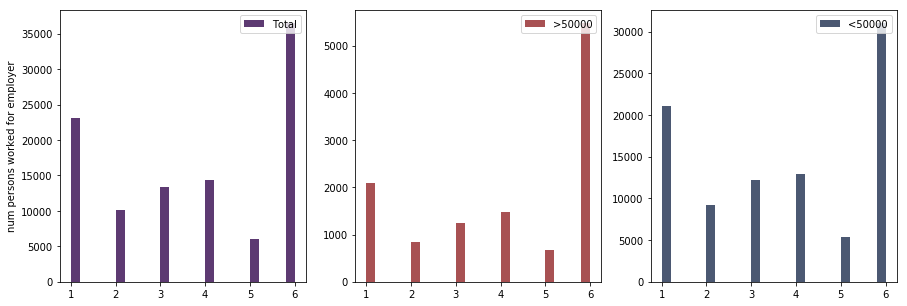

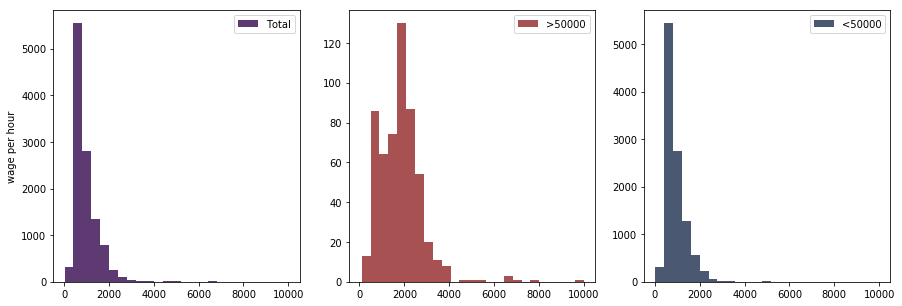

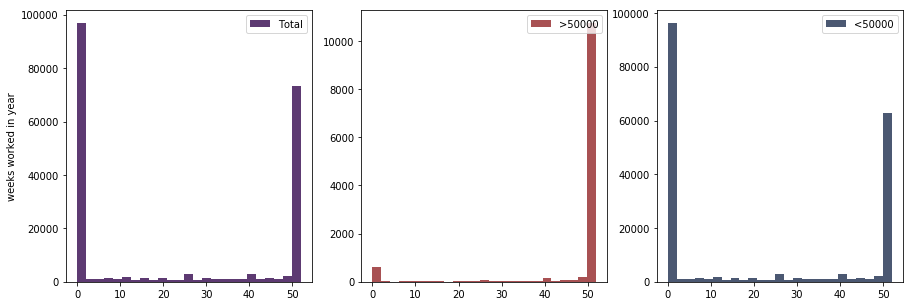

In [153]:
compare_hist('age')
compare_hist('capital gains', 10000.0)
compare_hist('capital losses', 100.0)
compare_hist('dividends from stocks', 5000.0)
compare_hist('num persons worked for employer')
compare_hist('wage per hour', 10.0)
compare_hist('weeks worked in year', -0.01)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


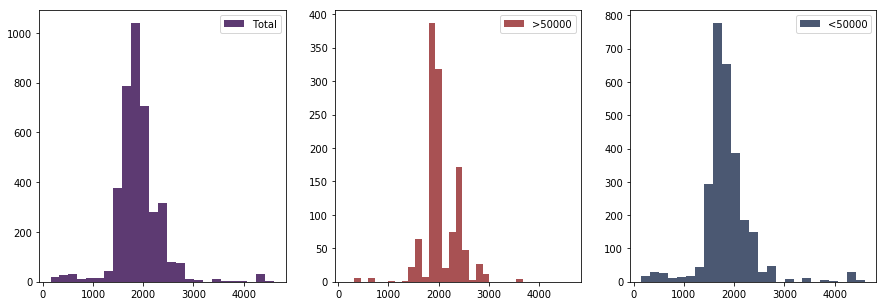

In [134]:
compare_hist('capital losses', 100.0)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


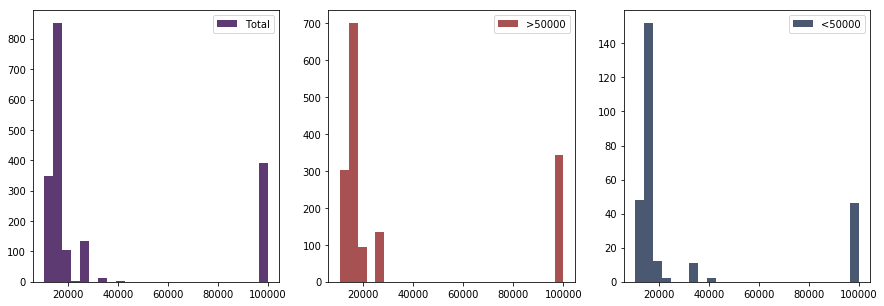

In [130]:
# Distribution of capital gains about 10,000 USD
colors = {
    'tot': '#5D3A72',
    'pos': '#A85153',
    'neg': '#4B5872'
}
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=True, sharey=False)
ax[0].hist(census_df[census_df['capital gains'] > 10000.0]['capital gains'].values , bins=25, color=colors['tot'], label='Total')
ax[1].hist(census_df[(census_df['capital gains'] > 10000.0) & (census_df['target'] == 1)]['capital gains'].values, bins=25, color=colors['pos'], label='>50000')
ax[2].hist(census_df[(census_df['capital gains'] > 10000.0) & (census_df['target'] == 0)]['capital gains'].values, bins=25, color=colors['neg'], label='<50000')
[a.legend(loc='upper right') for a in ax]
fig.show()

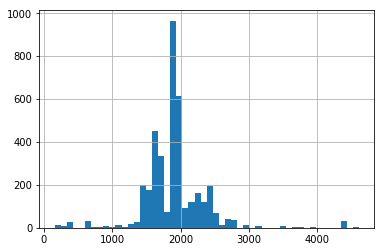

In [67]:
# Capital losses are much more evenly distributed - ultra-wealthy win big but don't often lose big
census_df[census_df['capital losses'] > 100.0]['capital losses'].hist(bins=50)
plt.show()

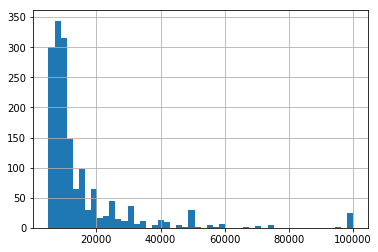

In [81]:
# Dividends from stocks
census_df[census_df['dividends from stocks'] > 5000.0]['dividends from stocks'].hist(bins=50)
plt.show()

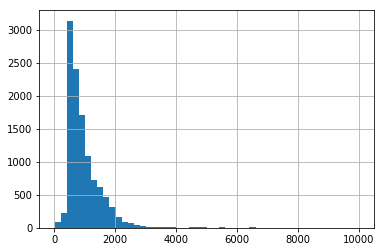

In [86]:
# Wages per hour
census_df[census_df['wage per hour'] > 10.0]['wage per hour'].hist(bins=50)
plt.show()

In [25]:
# Only superficial sign of irregularities are in the 

0            0
1            0
2            0
3            0
4            0
5         1200
6            0
7            0
8          876
9            0
10           0
11           0
12           0
13           0
14           0
15           0
16           0
17           0
18           0
19           0
20           0
21           0
22         500
23           0
24           0
25           0
26           0
27           0
28           0
29           0
30           0
31           0
32           0
33           0
34           0
35           0
36           0
37           0
38           0
39           0
40           0
41           0
42           0
43           0
44           0
45           0
46           0
47           0
48           0
49         400
50           0
51           0
52           0
53           0
54           0
55           0
56           0
57           0
58           0
59           0
60           0
61           0
62           0
63           0
64           0
65           0
66        